In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit
from scipy import interpolate
import pickle

from bfunc import bfunc00,bfunc01,bfunc02

Data load and region parameters

In [3]:
name = 'HV'

In [4]:
reg = 'HV'

In [5]:
pickle_in = open('SFresults//' + name + '.pkl',"rb")
SFresults = pickle.load(pickle_in)

In [6]:
B = SFresults['b2']
r = SFresults['s']
s0 = SFresults['s0']   
m = SFresults['m'] 
sig2 = SFresults['sig2'] 
r0 = SFresults['r0'] 
noise = B.mean()*0.05

In [7]:
model02 = lmfit.Model(bfunc02)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [8]:
relative_uncertainty = 0.1
weights = 1.0 / (relative_uncertainty * B)
weights[r > r0] /= 1.5

In [9]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
#model02.set_param_hint("sig2", value=sig2, vary=False)
#model02.set_param_hint("s0", min=0.2)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2        nan        0      inf     True    


In [10]:
result2 = model02.fit(
    B, 
    weights=weights,
    r = r, r0 = r0, m = m, s0 = s0, noise = noise, sig2=sig2,
)

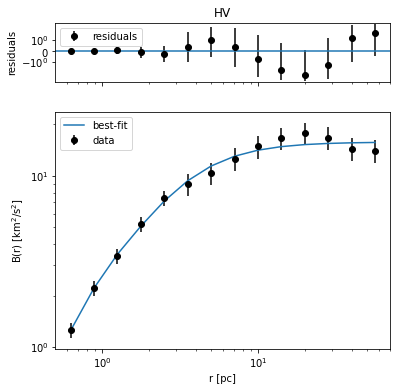

In [11]:
fig, _ = result2.plot( 'ko')
fig.axes[0].set(
    title=reg,
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
);

plt.savefig('Imgs//SF//' + reg + '.pdf', bbox_inches='tight')



In [12]:
CIresults = {'resultCI' : result2,
            'Rmax/r0' : r.max()/result2.params['r0'].value,
            'lT' : (r[3]/2**0.5)*((result2.params['r0'].value/r[3])**(result2.params['m'].value/2))
          }

In [13]:
f = open('CIresults//' + name +'.pkl',"wb")
pickle.dump(CIresults,f)
f.close()

In [14]:
print(result2.fit_report())

[[Model]]
    Model(bfunc02)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 14
    # variables        = 5
    chi-square         = 3.54274842
    reduced chi-square = 0.39363871
    Akaike info crit   = -9.23816318
    Bayesian info crit = -6.04287654
[[Variables]]
    r0:     3.00015519 +/- 0.29397451 (9.80%) (init = 2.724654)
    sig2:   7.48707902 +/- 0.41063785 (5.48%) (init = 7.864699)
    m:      1.74289235 +/- 0.16659796 (9.56%) (init = 1.5)
    s0:     0.34088762 +/- 0.10063508 (29.52%) (init = 0.9263956)
    noise:  0.80522732 +/- 0.40751603 (50.61%) (init = 0.5211104)
[[Correlations]] (unreported correlations are < 0.100)
    C(s0, noise)   =  0.941
    C(r0, m)       = -0.688
    C(sig2, m)     = -0.564
    C(r0, s0)      =  0.541
    C(sig2, noise) = -0.461
    C(r0, sig2)    =  0.456
    C(r0, noise)   =  0.434
    C(sig2, s0)    = -0.336
    C(m, s0)       = -0.135
    C(m, noise)    =  0.118


In [15]:
for p in result2.model.param_names:
    result2.params[p].stderr = result2.params[p].value * 0.1

In [16]:
result2.conf_interval()
print(result2.ci_report())

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=-1.0 < 1e-05 at iteration 2 and prob(s0=0.27271009924335554) = 0.0 < max(sigmas).
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=-0.426455665047342 < 1e-05 at iteration 3 and prob(noise=0.5636591258788853) = 0.06291796573180332 < max(sigmas).
  warn(errmsg)


          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0   :  -0.89329  -0.63311  -0.40900   3.00016  +0.33985  +0.86193  +2.21723
 sig2 :  -1.45171  -0.85690  -0.40721   7.48708  +0.89240  +1.37935  +2.15862
 m    :  -0.75864  -0.39338  -0.17342   1.74289  +0.17778  +0.41400  +0.80449
 s0   :      -inf      -inf      -inf   0.34089  +0.08300  +0.16934  +0.30181
 noise:      -inf      -inf      -inf   0.80523  +0.26287  +0.44712  +0.65322


In [17]:
plt.style.use([
    "seaborn-poster",
])

In [18]:
plot_limits = {
    "s0": [0.0, 0.1],
    "m": [.5, .5],
    "r0": [0.1, 1.0],
    "noise": [0.0, 0.5],
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('M8')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "s0"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [19]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 7.2552220821380615 seconds ---
